<h1>Practice - Text Clustering and Topic Modeling</h1>


### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [1]:
# %%capture
# !pip install bertopic datasets openai datamapplot

# **ArXiv Articles: Computation and Language**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/9_cleaned_papers.csv'

try:
  df = pd.read_csv(file_path, nrows=20000)
  print("Doc file thanh cong")
  print("kich thuoc du lieu dang xu ly: ", df.shape)
  print("-"*20)
  print("DANH SACH COT TRONG FILE")
  print(df.columns.tolist())
  print("-"*20)
except FileNotFoundError:
  print("Chua tim thay file")



Mounted at /content/drive
Doc file thanh cong
kich thuoc du lieu dang xu ly:  (20000, 2)
--------------------
DANH SACH COT TRONG FILE
['title', 'abstract']
--------------------


In [3]:
#1. Xu ly du lieu trong
# xoa cac dong ma cot 'abstract' bi trong (NAN)
df = df.dropna(subset=['abstract'])

# 2. Chuyen du lieu thanh list de dua vao mo hinh
#.astype(str) dam bao tat ca du lieu la van ban, tranh loi so hoc
abstracts = df['abstract'].astype(str).tolist()
titles = df['title'].fillna("No Title").astype(str).tolist()

# 3. Kiểm tra kết quả cuối cùng
print(f"✅ Đã chuẩn bị xong dữ liệu!")
print(f"Tổng số bài báo sẽ xử lý: {len(abstracts)}")
print("-" * 30)
print("Ví dụ bài đầu tiên:")
print(f"Tiêu đề: {titles[0]}")
print(f"Tóm tắt (100 ký tự đầu): {abstracts[0][:100]}...")

✅ Đã chuẩn bị xong dữ liệu!
Tổng số bài báo sẽ xử lý: 20000
------------------------------
Ví dụ bài đầu tiên:
Tiêu đề: Dynamic Backtracking
Tóm tắt (100 ký tự đầu): Because of their occasional need to return to shallow points in a search
tree, existing backtracking...


# **A Common Pipeline for Text Clustering**

## **1. Embedding Documents**

In [4]:
from sentence_transformers import SentenceTransformer

# su mo hinh ngon ngu loai nho da duoc huan luyen truoc
embedding_model = SentenceTransformer('thenlper/gte-small')
# chuyen doi cac abstract(tom tat)thanh day so vector, abstract la danh sach 20000 bai tom tat roi hien thi duoi dang thanh %
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [5]:
# Check the dimensions of the resulting embeddings
embeddings.shape

(20000, 384)

## **2. Reducing the Dimensionality of Embeddings**

In [6]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
# giam 384 chieu xuong 5 chieu quan trong nhat, n_components=5 -> nen du lieu xuong 5 chieu
# min_dist =0.0 la khoang cach toi thieu cua cac diem du lieu sau khi nén
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## **3. Cluster the Reduced Embeddings**

In [7]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


62

## **Inspecting the Clusters**

Manually inspect the first three documents in cluster 0:

In [8]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

Federated learning (FL) is a distributed model for deep learning that
integrates client-server architecture, edge computing, and real-time
intelligence. FL has the capability of revolutionizing machine learning (ML)
but lacks in the practicality of implementation due to technological
limitations, co... 

Federated Learning (FL) bridges the gap between collaborative machine
learning and preserving data privacy. To sustain the long-term operation of an
FL ecosystem, it is important to attract high quality data owners with
appropriate incentive schemes. As an important building block of such incentive
... 

Federated Learning, a new machine learning paradigm enhancing the use of edge
devices, is receiving a lot of attention in the pervasive community to support
the development of smart services. Nevertheless, this approach still needs to
be adapted to the specificity of the pervasive domain. In particu... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [9]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Static Plot

(np.float64(-0.9989154294133187),
 np.float64(11.507916893064976),
 np.float64(-0.3252759002149105),
 np.float64(11.611405985802412))

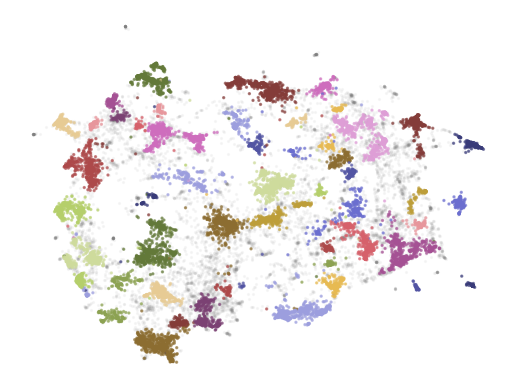

In [10]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

# From Text Clustering to Topic Modeling

## **BERTopic: A Modular Topic Modeling Framework**

In [11]:
# install bertopic
!pip install bertopic datasets openai datamapplot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.5/168.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 23.6 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5969 sha256=bf49f3cfa844f5b6388675f01250fb23a5dc502f6c7d422d1365d711e5c28552
  Stored in directory: /root/.cache/pip/wheels/86/02/24/506ac193949f48c8bec599b613d722bd64a83063a190b3bff7
Successfully built Pyqtree
  Attempting uninstall: dask
    Found exis

In [12]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-11-30 02:35:13,200 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-30 02:35:58,543 - BERTopic - Dimensionality - Completed ✓
2025-11-30 02:35:58,547 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-30 02:36:00,880 - BERTopic - Cluster - Completed ✓
2025-11-30 02:36:00,893 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-30 02:36:06,780 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [13]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8497,-1_the_of_and_to,"[the, of, and, to, in, we, for, is, that, this]",[This paper proposes an intent-aware multi-age...
1,0,566,0_game_games_player_the,"[game, games, player, the, of, to, playing, in...",[Combinations of Monte-Carlo tree search and D...
2,1,557,1_ontology_ontologies_of_the,"[ontology, ontologies, of, the, web, and, know...",[Building an ontology is not only a time-consu...
3,2,499,2_traffic_driving_the_and,"[traffic, driving, the, and, to, vehicle, vehi...",[Traffic forecasting is an important prerequis...
4,3,473,3_explanations_xai_explanation_ai,"[explanations, xai, explanation, ai, explainab...",[Explainability has been a challenge in AI for...
...,...,...,...,...,...
57,56,57,56_neural_physics_temperature_equations,"[neural, physics, temperature, equations, the,...",[Physics-informed neural networks allow models...
58,57,56,57_narrative_story_stories_events,"[narrative, story, stories, events, narratives...",[Many implicit inferences exist in text depend...
59,58,54,58_summarization_summaries_summary_document,"[summarization, summaries, summary, document, ...",[Text summarization has been a crucial problem...
60,59,53,59_patients_patient_icu_prediction,"[patients, patient, icu, prediction, clinical,...",[Delirium is an acute confusional state that h...


Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:

In [14]:
topic_model.get_topic(0)

[('game', np.float64(0.049528022786223175)),
 ('games', np.float64(0.03525912041626941)),
 ('player', np.float64(0.01770179616952092)),
 ('the', np.float64(0.013870291815725203)),
 ('of', np.float64(0.013386497942712452)),
 ('to', np.float64(0.012851294105540893)),
 ('playing', np.float64(0.012622061621871364)),
 ('in', np.float64(0.012564131175894626)),
 ('players', np.float64(0.01225057983283463)),
 ('and', np.float64(0.012085077435234121))]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [15]:
topic_model.find_topics("topic modeling")

([57, 21, 58, -1, 55],
 [np.float32(0.90529144),
  np.float32(0.9007354),
  np.float32(0.89804006),
  np.float32(0.89561164),
  np.float32(0.89469564)])

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [16]:
topic_model.get_topic(22)

[('knowledge', np.float64(0.036099313165594026)),
 ('graph', np.float64(0.027631717808551143)),
 ('embedding', np.float64(0.026599243258238654)),
 ('kg', np.float64(0.025709268633640345)),
 ('entities', np.float64(0.022894915810841535)),
 ('graphs', np.float64(0.020801434751582804)),
 ('kgs', np.float64(0.0191821113750336)),
 ('relations', np.float64(0.016556225149015134)),
 ('link', np.float64(0.016362721461912248)),
 ('entity', np.float64(0.01592911284169352))]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:

In [17]:
# Chọn một bài báo bất kỳ trong dữ liệu của bạn (ví dụ bài ở vị trí index 100)
index_can_kiem_tra = 100

title_bai_bao = titles[index_can_kiem_tra]
topic_id = topic_model.topics_[index_can_kiem_tra]

print(f"Tên bài báo: {title_bai_bao}")
print(f"Bài báo này thuộc chủ đề số: {topic_id}")

# Xem chủ đề đó nói về cái gì
if topic_id != -1:
    print(f"Các từ khóa của chủ đề {topic_id}:")
    print(topic_model.get_topic(topic_id))
else:
    print("Bài báo này là Nhiễu (Outliers) - không thuộc chủ đề cụ thể nào.")

Tên bài báo: The Computational Complexity of Probabilistic Planning
Bài báo này thuộc chủ đề số: 6
Các từ khóa của chủ đề 6:
[('planning', np.float64(0.05905099258077652)), ('plan', np.float64(0.025800035999728868)), ('plans', np.float64(0.019003438825538326)), ('of', np.float64(0.01448767597678095)), ('domains', np.float64(0.014480218227999298)), ('planners', np.float64(0.01438591274096491)), ('the', np.float64(0.014349218045636552)), ('domain', np.float64(0.013797616813864618)), ('actions', np.float64(0.01364359091801055)), ('that', np.float64(0.013377537996483503))]


It is! We expected it might be because there are non-LDA specific words in the topic describtion such as "clustering" and "topic".

### **Visualizations**

**Visualize Documents**

In [18]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [19]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [20]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [21]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

In [22]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,game | games | player | the | of,games | game | playing | ai | chess
1,1,ontology | ontologies | of | the | web,ontology | ontologies | ontological | semantic...
2,2,traffic | driving | the | and | to,traffic | prediction | driving | forecasting |...
3,3,explanations | xai | explanation | ai | explai...,explainability | explaining | explanations | e...
4,4,logic | programs | asp | answer | programming,logics | logic | reasoning | programming | sem...


### Maximal Marginal Relevance

In [23]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,game | games | player | the | of,game | player | the | playing | ai
1,1,ontology | ontologies | of | the | web,ontology | web | semantic | owl | data
2,2,traffic | driving | the | and | to,traffic | to | prediction | data | urban
3,3,explanations | xai | explanation | ai | explai...,explanations | xai | ai | explainability | cou...
4,4,logic | programs | asp | answer | programming,semantics | set | program | stable | reasoning


## Text Generation



### Flan-T5

In [24]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


,Topic,Original,Updated
0,0,game | games | player | the | of,Science/Tech | | | |
1,1,ontology | ontologies | of | the | web,Science/Tech | | | |
2,2,traffic | driving | the | and | to,traffic speed prediction | | | |
3,3,explanations | xai | explanation | ai | explai...,Explainable Artificial Intelligence | | | |
4,4,logic | programs | asp | answer | programming,Programming | | | |


### OpenAI

In [ ]:
import openai
from bertopic.representation import OpenAI
from google.colab import  userdata # thu vien lay secret


# 1. Lay api key tu Colab Secret

try:
  my_api_key = 'OPENAI_API_KEY'
except:
  print("loi khong tim thay secret")
  my_api_key = "ERROR"


if my_api_key != "ERROR":

  prompt = """
  I have a topic that contains the following documents:
  [DOCUMENTS]

  The topic is described by the following keywords: [KEYWORDS]

  Based on the information above, extract a short topic label in the following format:
  topic: <short topic label>
  """

  # Update our topic representations using GPT-3.5
  client = openai.OpenAI(api_key=my_api_key)
  representation_model = OpenAI(
      client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
  )
  topic_model.update_topics(abstracts, representation_model=representation_model)

  # Show topic differences
  topic_differences(topic_model, original_topics)
else:
  print("Vui lòng cấu hình API Key trước khi chạy đoạn này.")

100%|██████████| 156/156 [02:13<00:00,  1.17it/s]


,Topic,Original,Updated
0,0,speech | asr | recognition | end | acoustic,Leveraging External Data for Improving Low-Res...
1,1,medical | clinical | biomedical | patient | he...,Improved Representation Learning for Biomedica...
2,2,sentiment | aspect | analysis | reviews | opinion,"""Advancements in Aspect-Based Sentiment Analys..."
3,3,translation | nmt | machine | neural | bleu,Neural Machine Translation Enhancements
4,4,summarization | summaries | summary | abstract...,Document Summarization Techniques


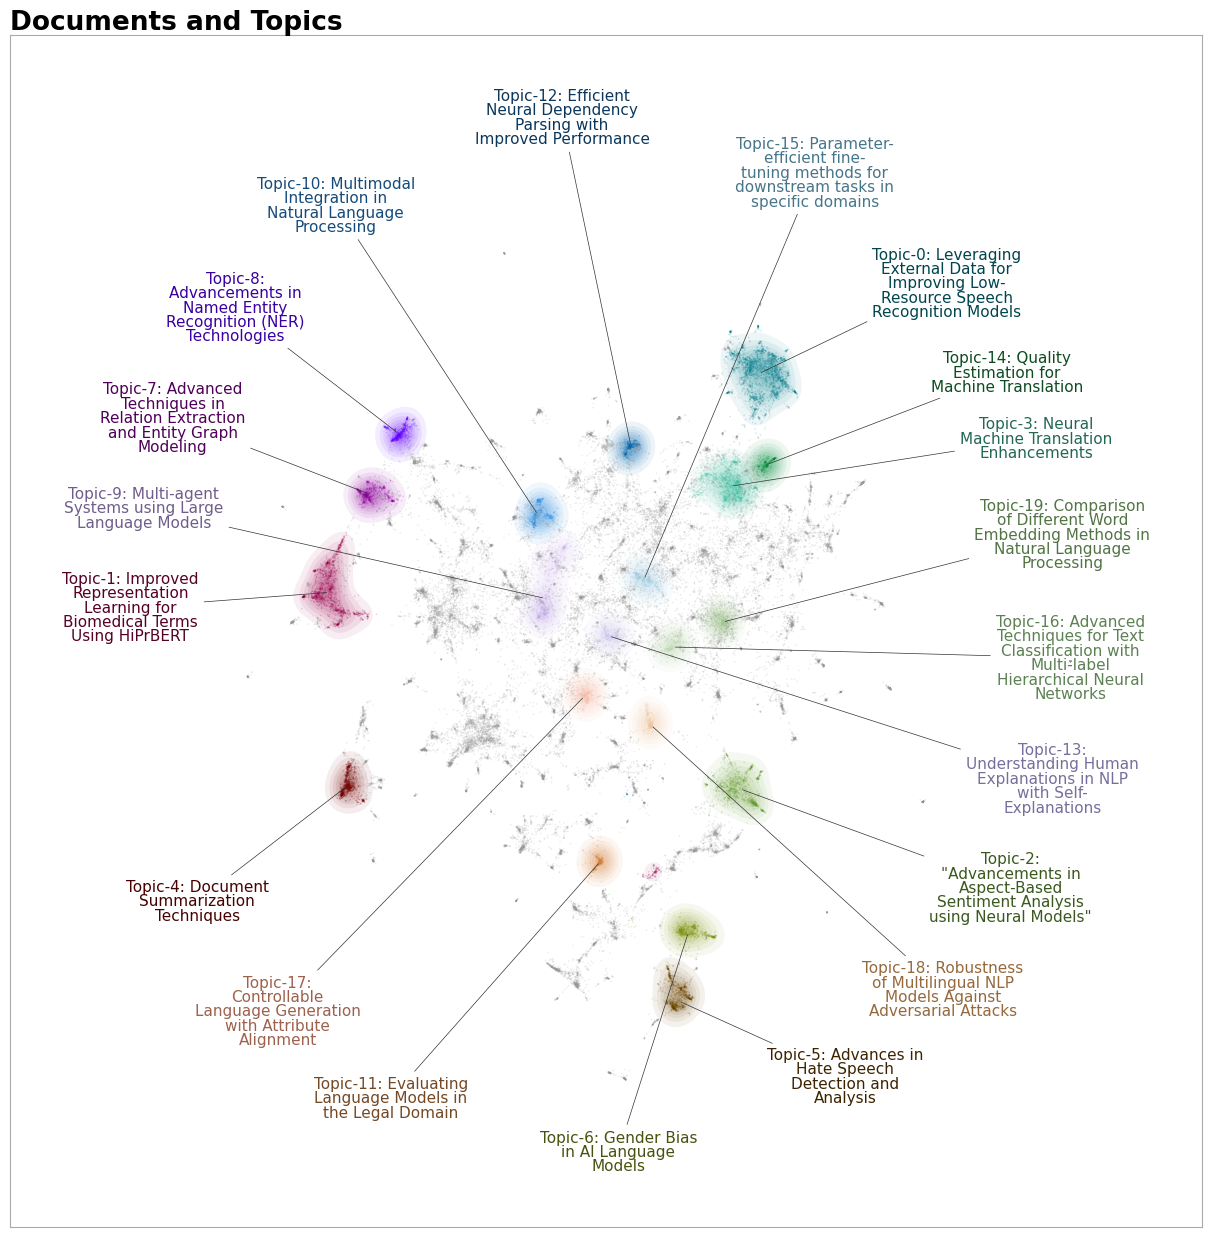

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)


## **BONUS**: Word Cloud

Make sure to pip install `wordcloud` first in order to follow this bonus:


First, we need to make sure that each topic is described by a bit more words than just 10 as that would make for a much more interesting wordcloud.

In [ ]:
topic_model.update_topics(abstracts, top_n_words=500)

Then, we can run the following code to generate the wordcloud for our topic modeling topic:

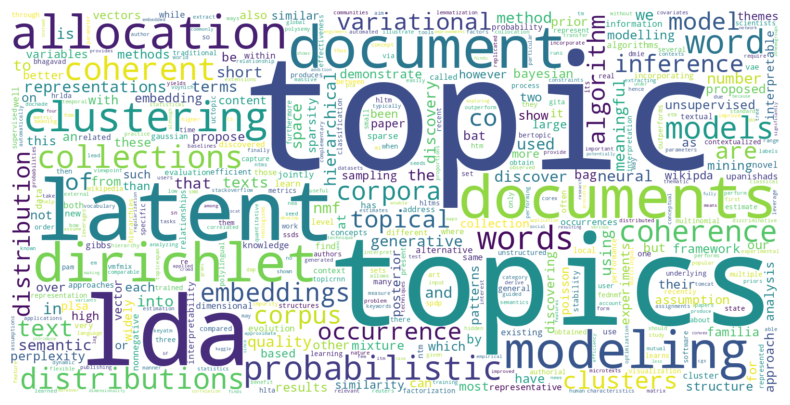

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)